<a href="https://colab.research.google.com/github/iankim20/-/blob/AI-and-medicine/classification_dist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NII 볼륨 정보 읽는 예제

## Google drive 연결

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
!ls /content
!ls /content/LITS17
#!ls '/gdrive/Team Drives/SevAIClass/LITS17'

sample_data
ls: cannot access '/content/LITS17': No such file or directory


In [ ]:
!pip install nibabel

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import os, sys, time
import nibabel as nib
from skimage import measure 
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

NII_ROOT = '/gdrive/Team Drives/SevAIClass/LITS17'

## NII 볼륨에서 그림 파일을 생성하여 폴더에 저장하는 코드
### 1) standalone 환경에서는 나쁘지 않으나, google drive 특성상 다운이 잦아 사용이 힘듬.

### 2) VM에 만들고 12시간만 사용하는 방법.

In [ ]:
cnt = 0
IMG_ROOT = '/content/LITS17'
liver_dir = os.path.join(IMG_ROOT, 'liver')
nonliver_dir = os.path.join(IMG_ROOT, 'nonliver')
if (not os.path.isdir(IMG_ROOT)):
  os.makedirs(IMG_ROOT)
if (not os.path.isdir(liver_dir)):
  os.makedirs(liver_dir)
if (not os.path.isdir(nonliver_dir)):
  os.makedirs(nonliver_dir)


since = time.time()  

for pfile in sorted(glob.glob(os.path.join(NII_ROOT, 'volume*.nii'))):
  pmfile = pfile.replace('volume', 'segmentation')
  if (not os.path.isfile(pmfile)): # 마스크 없는 볼륨은 버림
    print('[ERROR] {}'.format(pmfile))
    continue
  print(pfile)
  pid = os.path.basename(pfile).split('.')[0]

  im = nib.load(pfile)
  vol = im.get_fdata()
  vol = np.transpose(vol, (1, 0, 2))
  vol = np.clip(vol, -175, 275)
  vol = np.interp(vol, (-175, 275), (0, 255))

  mask = nib.load(pmfile)
  maskvol = mask.get_fdata()

  for z in range(vol.shape[2]):
    slice = vol[:, :, z]
    mslice = maskvol[:, :, z]
    if (np.max(mslice) < 1): 
      clsstr = 'nonliver'
    else:
      clsstr = 'liver'
    
    pdstfile = os.path.join(IMG_ROOT, clsstr, '{}_{:04d}.png'.format(pid, z))
    #print(pdstfile)
    
    pil_im = Image.fromarray(slice.astype(np.uint8))
    pil_im = pil_im.convert("L").resize((224, 224), resample=Image.BILINEAR).convert("RGB")
    pil_im.save(pdstfile,"PNG")
    
    #break # for debug
  #break # for debug

  
time_elapsed = time.time() - since
print('Finished in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

/gdrive/Team Drives/SevAIClass/LITS17/volume-0.nii
/gdrive/Team Drives/SevAIClass/LITS17/volume-1.nii
/gdrive/Team Drives/SevAIClass/LITS17/volume-10.nii
/gdrive/Team Drives/SevAIClass/LITS17/volume-100.nii
/gdrive/Team Drives/SevAIClass/LITS17/volume-101.nii
/gdrive/Team Drives/SevAIClass/LITS17/volume-102.nii
/gdrive/Team Drives/SevAIClass/LITS17/volume-103.nii
/gdrive/Team Drives/SevAIClass/LITS17/volume-104.nii
/gdrive/Team Drives/SevAIClass/LITS17/volume-105.nii
/gdrive/Team Drives/SevAIClass/LITS17/volume-106.nii
/gdrive/Team Drives/SevAIClass/LITS17/volume-107.nii
/gdrive/Team Drives/SevAIClass/LITS17/volume-108.nii
/gdrive/Team Drives/SevAIClass/LITS17/volume-109.nii
/gdrive/Team Drives/SevAIClass/LITS17/volume-11.nii
/gdrive/Team Drives/SevAIClass/LITS17/volume-110.nii
/gdrive/Team Drives/SevAIClass/LITS17/volume-111.nii
/gdrive/Team Drives/SevAIClass/LITS17/volume-112.nii
/gdrive/Team Drives/SevAIClass/LITS17/volume-113.nii
/gdrive/Team Drives/SevAIClass/LITS17/volume-114.nii

KeyboardInterrupt: ignored

## ImageFolder DataLoader

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchvision import utils, datasets, models
from torch.utils.data import Dataset, DataLoader
import time, os, sys, copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.ImageFolder(root='/content/LITS17', transform=transform)
trainloader = DataLoader(trainset, batch_size=4, shuffle=False, num_workers=1)

classes = ('liver', 'nonliver')

torch.Size([4, 3, 224, 224])


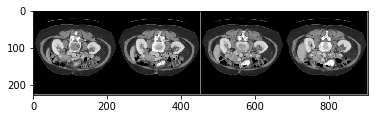

liver liver liver liver


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
num = images.shape[0]
print(images.shape) # [nbatch, nch, y, x]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(num)))

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        scheduler.step()
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in trainloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            #print(inputs.shape)
            #print(labels.shape)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            #print(running_loss)

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = running_corrects.double() / len(trainloader)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    return model

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2) # only 2 classes

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------
Loss: 0.0493 Acc: 3.9931
Epoch 1/1
----------


KeyboardInterrupt: ignored